In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
import glob
from matplotlib import pyplot as plt
%matplotlib inline
!pip install nilearn
import nilearn

In [0]:
ff = sorted(glob.glob('drive/My Drive/Skull_stripped_images/*'))   #For reading a folder
N=64    #resized image dimensions (N, N)

import cv2
images = []    #contains the training data sliced over all 3 axes

#Have used nibabel library which has been imported as 'nib' to read the Nifti images 

for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_fdata()
    for k in range(a.shape[0]):                                                                                                  
        temp = cv2.resize(a[k,:,:], (N, N), interpolation = cv2.INTER_LINEAR)        #INTER_CUBIC (another type of interpolation)                                     
        images.append(temp)
    for k in range(a.shape[1]):
        temp = cv2.resize(a[:,k,:], (N, N), interpolation = cv2.INTER_LINEAR) 
        images.append(temp)
    for k in range(a.shape[2]):
        temp = cv2.resize(a[:,:,k], (N, N), interpolation = cv2.INTER_LINEAR) 
        images.append(temp)
           
print (a.shape)
print(len(images))

(260, 311, 260)


'\nfor f in range(len(ff)):\n    a = nilearn.image.load_img(ff[f])\n    a = a.get_data()\n    for k in range(a.shape[0]):                                                                                                   #for k in range(a.shape[0]):\n        temp = cv2.resize(a[k,:,:], (N, N), interpolation = cv2.INTER_CUBIC)                                                #temp = cv2.resize(a[:,100+k,:], (N, N), interpolation = cv2.INTER_CUBIC) \n        images.append(temp)\n    for k in range(a.shape[1]):\n        temp = cv2.resize(a[:,k,:], (N, N), interpolation = cv2.INTER_CUBIC) \n        images.append(temp)\n    for k in range(a.shape[2]):\n        temp = cv2.resize(a[:,:,k], (N, N), interpolation = cv2.INTER_CUBIC) \n        images.append(temp)\n           \nprint (a.shape)\nlen(images)\n\n'

Training images obtained by slicing along X axis


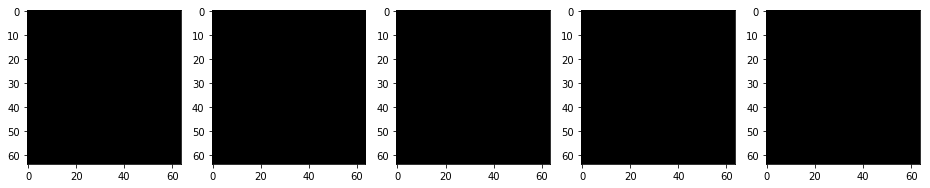

Training images obtained by slicing along Y axis


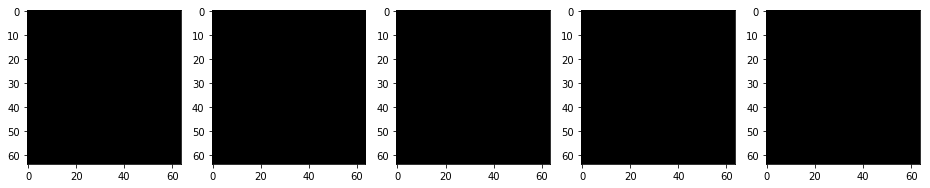

Training images obtained by slicing along Z axis


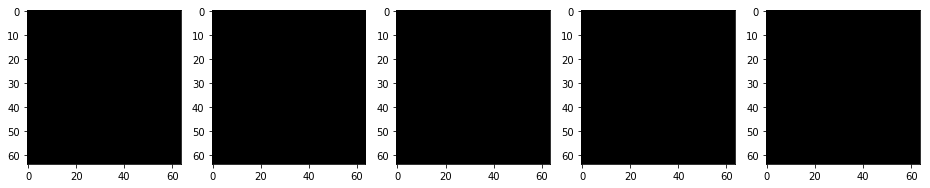

In [0]:
plt.figure(figsize=(16, 4))
print("Training images obtained by slicing along X axis")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i],cmap='gray')                                       #plt.imshow(images[i, ..., 0], cmap='gray')
plt.show()    

   
    
#ax = plt.subplots()
#ax.grid(False)

plt.figure(figsize=(16, 4))
print("Training images obtained by slicing along Y axis")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i+260],cmap='gray')                                   #plt.imshow(images[i+260, ..., 260], cmap='gray')

plt.show()    
#ax = plt.subplots()
#ax.grid(False)


plt.figure(figsize=(16, 4))
print("Training images obtained by slicing along Z axis")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i+571],cmap='gray')                                    # plt.imshow(images[i+571, ..., 571], cmap='gray')
plt.show()    

#ax = plt.subplots()
#ax.grid(False)




In [0]:
images = np.asarray(images)  #converting list to a numpy array (first dimension refers to the #of samples and the second and the third are the 2D image dimension)
images = images.reshape(-1,N,N,1)  #-1 is generally used for an unknown dimension

In [0]:
maximum = np.max(images)    #Normalization over all the training images to get the intensity values between 0 and 1 
minimum = np.min(images)

images = (images - minimum) / (maximum - minimum)

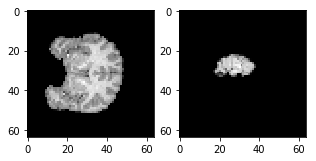

In [0]:
plt.figure(figsize=[5,5])

# Display random images from the training data
plt.subplot(121)
plt.imshow(images[450][:,:,0], cmap='gray')

plt.subplot(122)
plt.imshow(images[220][:,:,0], cmap='gray')

In [0]:
ff = sorted(glob.glob('drive/My Drive/Model_Output_Bias_images/*'))   #For reading a folder
N=64

import cv2
images_truth = []    #contains the ground truth for training data sliced over all 3 axes


for f in range(len(ff)):
    a = nib.load(ff[f])
    a = a.get_fdata()
    for k in range(a.shape[0]):                                                                                                   
        temp = cv2.resize(a[k,:,:], (N, N), interpolation = cv2.INTER_LINEAR)                                               
        images_truth.append(temp)
    for k in range(a.shape[1]):
        temp = cv2.resize(a[:,k,:], (N, N), interpolation = cv2.INTER_LINEAR) 
        images_truth.append(temp)
    for k in range(a.shape[2]):
        temp = cv2.resize(a[:,:,k], (N, N), interpolation = cv2.INTER_LINEAR) 
        images_truth.append(temp)
           
print(a.shape)
print(len(images_truth))

images_truth = np.asarray(images_truth)  #converting list to a numpy array (first dimension refers to the #of samples and the second and the third are the 2D image dimension)
images_truth = images_truth.reshape(-1,N,N,1)  #-1 is generally used for an unknown dimension

m = np.max(images_truth)    #Normalization over the ground truth for all the training images to get the intensity values between 0 and 1
mi = np.min(images_truth)

images_truth = (images_truth - mi) / (m - mi)

(260, 311, 260)


In [0]:
for i in range(len(images_truth)):
    for j in range(N):
      for k in range(N):
        if (images[i,j,k,0] == 0): #images array contains data from skull striped images; 
          images_truth[i,j,k,0] = 0 #this is done to set those pixel values that are outside the brain in the images ground truth to 0
        

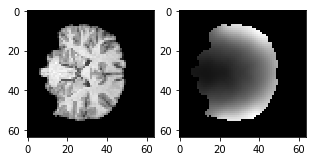

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images_truth,
                                                             test_size=0.2,
                                                             random_state=13)

plt.figure(figsize=[5,5])

# Display an image in training data
plt.subplot(121)
plt.imshow(train_X[450][:,:,0], cmap='gray')

# Display the corresponding ground truth for the training data
plt.subplot(122)
plt.imshow(train_ground[450][:,:,0], cmap='gray')


In [0]:
import os
import cv2
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
#from keras.callbacks import ModelCheckpoint
#from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras.losses import mean_absolute_error,mean_squared_error
from keras import regularizers
from keras import backend as K

Using TensorFlow backend.


In [0]:
batch_size = 256
epochs = 100
inChannel = 1
x, y = N, N
input_img = Input(shape = (x, y, inChannel))

def autoencoder(input_img):
  
    #encoder
    
    conv1 = Conv2D(12, (7, 7), activation='relu', padding='same')(input_img) # N x N x 12
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(12, (7, 7), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(24, (7, 7), activation='relu', padding='same')(pool1) # N/2 x N/2 x 24
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(24, (7, 7), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
   

    #decoder
    
    conv3 = Conv2D(24, (7, 7), activation='relu', padding='same')(conv2) # N/2 x N/2 x 24
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(24, (7, 7), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    up1 = UpSampling2D((2,2))(conv3) 
    conv4 = Conv2D(12, (7, 7), activation='relu', padding='same')(up1) # N x N x 12
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(12, (7, 7), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(conv4) # N x N x 1
    return decoded

In [0]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop()) #a better metric (instead of mean squared error) to verify the performance would be 
autoencoder.summary()                                                 #to feed the corrected MRI images in Brainsuite and find out if the segmentation of the brain 
                                                                      #tissues is done right

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 12)        600       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 12)        48        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 12)        7068      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 12)        48        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 12)        0         
_________________________________________________________________
conv

In [0]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 26592 samples, validate on 6648 samples
Epoch 1/100
26592/26592 [==============================] - 43s 2ms/step - loss: 0.0535 - val_loss: 0.0321
Epoch 2/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0208 - val_loss: 0.0843
Epoch 3/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0084 - val_loss: 0.0438
Epoch 4/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0039 - val_loss: 0.0286
Epoch 5/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 6/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0025 - val_loss: 0.0116
Epoch 7/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0022 - val_loss: 0.0081
Epoch 8/100
26592/26592 [==============================] - 38s 1ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 9/100
26592/26592 [==============================

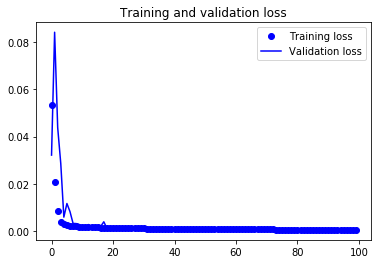

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
pred = autoencoder.predict(valid_X)

Ground truth for the Test Images


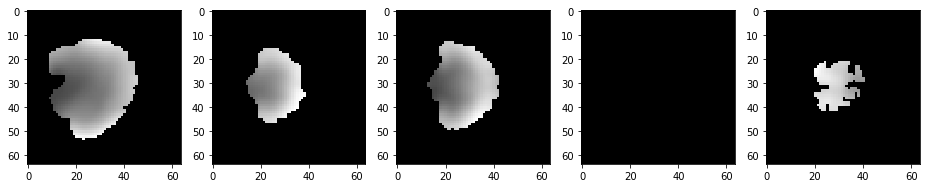

In [0]:
plt.figure(figsize=(16, 4))
print("Ground truth for the Test Images")
#Displaying the first five images from the ground truth of the test images

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i+200,:,:,0],cmap='gray')                                               #plt.imshow(valid_ground[i+200, ..., 205], cmap='gray')
plt.show()    

Reconstruction of Bias field from the Test Images


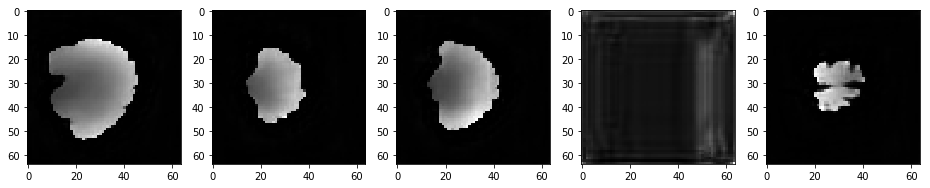

In [0]:
plt.figure(figsize=(16, 4))
print("Reconstruction of Bias field from the training dataset")
#Displaying the first five images from the prediction made by the auto encoder on the test images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i+200,:,:,0],cmap='gray')                                                                                           #plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [0]:
autoencoder.save('drive/My Drive/autoencoder_model.h5') #to save the weights of the trained model